In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')

In [41]:
import os
import json
import matplotlib.pyplot as plt
import matplotlib.cm
from utils import Trade, Resources, Goal
from collections import defaultdict

In [29]:
exp_path = "../.logs/1698480633466"
# exp_path = "../.logs/1698477062823"
with open(os.path.join(exp_path,"state.json")) as f:
    exp_state = json.load(f)

In [36]:
def load_states(paths):
    states = {}
    for exp_path in paths:
        with open(os.path.join(exp_path,"state.json")) as f:
            states[exp_path] = json.load(f)
    return states

In [76]:
def compute_metric_from_state(exp_state, metric_fn, metric_store: defaultdict):
    for agent_id, agent_state in enumerate(exp_state):
         metric_fn(agent_id, agent_state, metric_store)
    return metric_store

def agent_proposal_utility_fn(agent_id, agent_state, metric_store):
    for state in agent_state[1:]:
        if state['proposed_trade'] != "None":
            # convert string into objects
            resources = Resources.from_string(state['resources'])
            goals = Goal.from_string(state['goals'])
            proposed_trade = Trade.from_string(state['proposed_trade'])
            # mini hack to get the right sign
            marginal_utility = goals-resources if agent_id == 0 else resources-goals
            metric_store[agent_id].append(proposed_trade.utility(marginal_utility))

def agent_success_fn(agent_id, agent_state, metric_store):
    state = agent_state[-1]
    goals = Goal.from_string(state['goals'])
    resources = Resources.from_string(state['resources'])
    goal_reached = goals.goal_reached(resources)
    metric_store[agent_id] = goal_reached



In [91]:
def agent_proposal_utility(states):
    return [compute_metric_from_state(_, agent_proposal_utility_fn, defaultdict(list)) for _ in states.values()]

def agent_success(states):
    return [compute_metric_from_state(_, agent_success_fn, defaultdict(bool)) for _ in states.values()]

def agent_average_success(states):
    success = agent_success(states)
    return { k: sum([trial[k] for trial in success])/len(success)  for k in success[0].keys() }
                          

In [92]:
paths = [
    "../.logs/1698480633466",
    "../.logs/1698477062823",
    "../.logs/1698481270492",
    "../.logs/1698481933477",
    "../.logs/1698482232830"
]
states = load_states(paths)

In [93]:
proposal_utilities = agent_proposal_utility(states)
success = agent_success(states)
avg_success = agent_average_success(states)

<BarContainer object of 2 artists>

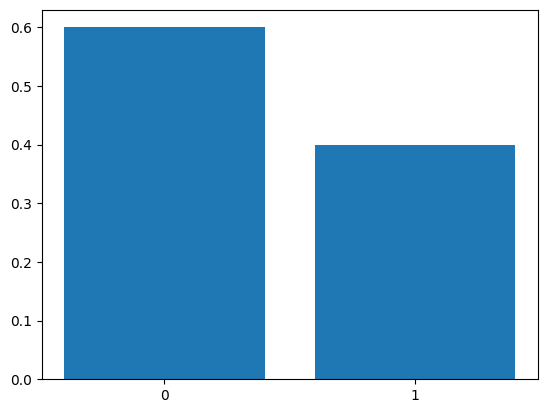

In [99]:
plt.bar(avg_success.keys(), avg_success.values(), tick_label=list(avg_success.keys()))

Text(0.5, 1.0, 'Trade Trajectories')

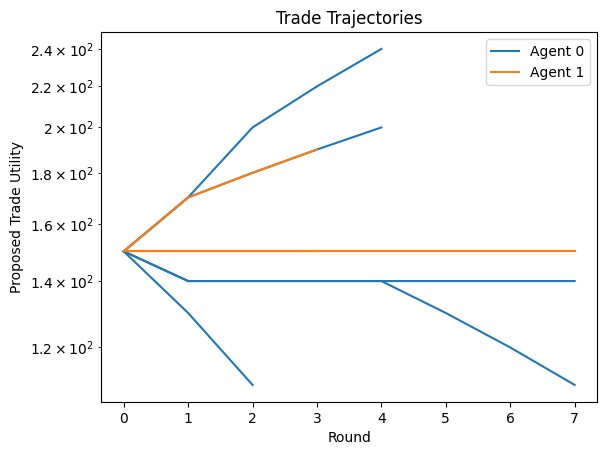

In [101]:
color = matplotlib.cm.datad['tab10']['listed']
for util in proposal_utilities:
    for idx, _ in enumerate(util.values()):
        plt.plot(_, color=color[idx])

plt.legend(['Agent 0', 'Agent 1'])
plt.xlabel('Round')
plt.ylabel('Proposed Trade Utility')
plt.yscale('log')
plt.title("Trade Trajectories")